In [135]:
# import
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os

In [136]:
# load data
# X_train_fpath = sys.argv[1]
# Y_train_fpath = sys.argv[2]
# X_test_fpath = sys.argv[3]
# output_fpath = sys.argv[4]

X_train_fpath = 'X_train'
Y_train_fpath = 'Y_train'
X_test_fpath = 'X_test'
output_fpath = 'output.csv'

X_train = np.genfromtxt(X_train_fpath, delimiter=',', skip_header=1)
Y_train = np.genfromtxt(Y_train_fpath, delimiter=',', skip_header=1)
X_test = np.genfromtxt(X_test_fpath, delimiter=',', skip_header=1)


In [137]:
# validation and shuffle(for batch)
def _shuffle(X, y):
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return X[randomize], y[randomize]
def set_validation(X, y, ratio=0.25):
    trainlen = int(round(len(X) * (1 - ratio)))
    return X[0:trainlen], y[0:trainlen], X[trainlen:None], y[trainlen:None]


In [138]:
# normalization
def normalize_0_1(X, train=True, col=None, X_min=None, X_max=None):
    if train is True:
        if col is None:
            col = np.arange(X.shape[1])
        X_max = X[:, col].max(0).reshape(1, -1)
        X_min = X[:, col].min(0).reshape(1, -1)
    X[:, col] = (X[:, col] - X_min) / (X_max - X_min)
    return X, X_max, X_min

def normalize_normal(X, train=True, col=None, X_mean=None, X_std=None):
    if train is True:
        if col is None:
            col = np.arange(X.shape[1])
        X_mean = X[:, col].mean(0).reshape(1, -1)
        X_std = X[:, col].std(0).reshape(1, -1)
    X[:, col] = (X[:, col] - X_mean) / (X_std)
    return X, X_mean, X_std


# col = [0, 1, 3, 4, 5, 7, 10, 12, 25, 26, 27, 28]
col = np.arange(X_train.shape[1])[X_train.mean(0) > 1]
X_train, X_mean, X_std = normalize_normal(X_train, col=col)



In [139]:
# logistic regression
def sigmoid(z):
    return np.clip(1 / (1 + np.exp(-z)), 1e-6, 1 - 1e-6)
def estimate_prob(x, w, b):
    return(sigmoid(np.add(np.matmul(x, w), b)))

# def estimate_prob(x, w, b):
#     return np.round(sigmoid_(np.dot(x, w) + b))

# def cross_validation(y_pred, y_true):
#     cross_entropy = - y_true.dot(np.log(y_pred)) - (1 - y_true).dot(np.log(1 - y_pred))
#     return cross_entropy
def cross_validation(y_pred, Y_label):
    # compute the cross entropy
    cross_entropy = -np.dot(Y_label, np.log(y_pred))-np.dot((1-Y_label), np.log(1-y_pred))
    return cross_entropy
def gradient(x, y_true, w, b):
    y_pred = estimate_prob(x, w, b)
    m = len(y_true)
    w_grad = -1 / m * ((x.T).dot(y_pred - y_true))
    b_grad = - 1 / m * np.sum((y_pred - y_true))
    return w_grad, b_grad
def _gradient_regularization(X, Y_label, w, b, lamda):
    # return the mean of the graident
    y_pred = estimate_prob(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.mean(np.multiply(pred_error.T, X.T), 1) + lamda * w
    b_grad = -np.mean(pred_error)
    return w_grad, b_grad
def regulization_gradient(x, y_true, w, b, lamba):
    y_pred = estimate_prob(x, w, b)
    m = len(y_true)
    w_grad = (-1 / m) * ((x.T).dot((y_true - y_pred))) + lamba * w
    b_grad = (- 1 / m) * np.sum(y_true - y_pred)
    return w_grad, b_grad
def regulization_loss(y_pred, y_true, lamba, w):
    return cross_validation(y_pred, y_true) + lamba * np.sum(np.square(w))
def accuracy(y_pred, y_true):
    acc = np.sum(y_pred == y_true) / len(y_pred)
    return acc



In [167]:
# run gradient
def run_gradient(x_train, y_train , learning_rate=0.01):
    validation_ratio=0.1225
    x_train, y_train, x_val, y_val = set_validation(X_train, Y_train, ratio=validation_ratio)
    w = np.zeros((x_train.shape[1],))
    b = np.zeros((1,))
    # r_w = np.zeros((x_train.shape[1],))
    # r_b = np.zeros((1,))
    regulization = True
    if regulization is True:
        lamba = 0.00001
    else:
        lamba = 0

    iteration = 50
    batch_size = 32
    # learning_rate = 0.001
    # decay_rate = 0.99
    step = 1  # for decay
    loss_train = []
    loss_val = []
    train_acc = []
    val_acc = []
    # run
    for epoch in range(iteration):
        x_train, y_train = _shuffle(x_train, y_train)
        for id in range(int(np.floor(len(y_train) / batch_size))):
            X = x_train[id * batch_size:(id + 1) * batch_size]
            Y = y_train[id * batch_size:(id + 1) * batch_size]

            w_grad, b_grad = _gradient_regularization(X, Y, w, b, lamba)
            w = w - learning_rate / np.sqrt(step) * w_grad
            b = b - learning_rate / np.sqrt(step) * b_grad

            step = step + 1
            # r_w = r_w * decay_rate + ((1 - decay_rate) * np.multiply(w_grad, w_grad))
            # r_b = r_b * decay_rate + ((1 - decay_rate) * np.multiply(b_grad, b_grad))
            # w = w - ((learning_rate / (np.sqrt(r_w) + 0.0000001)) * w_grad)
            # b = b - ((learning_rate / (np.sqrt(r_b) + 0.0000001)) * b_grad)

        # loss and acc for each iteration
        y_train_pred = estimate_prob(x_train, w, b)
        Y_train_pred = np.round(y_train_pred)
        train_acc.append(accuracy(Y_train_pred, y_train))
        loss_train.append(regulization_loss(y_train_pred, y_train, lamba, w) / len(y_train))

        y_val_pred = estimate_prob(x_val, w, b)
        Y_val_pred = np.round(y_val_pred)
        val_acc.append(accuracy(Y_val_pred, y_val))
        loss_val.append(regulization_loss(y_val_pred, y_val, lamba, w) / len(y_val))
    return w, b, train_acc, loss_train, val_acc, loss_val


w, b, train_acc, loss_train, val_acc, loss_val = run_gradient(X_train, Y_train, learning_rate=0.25)


In [168]:
train_acc[-1]


0.8477530449391012

In [169]:
val_acc[-1]

0.83855602907997

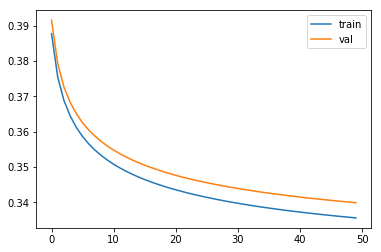

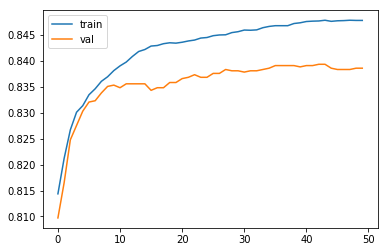

In [170]:
# plot
plt.plot(loss_train)
plt.plot(loss_val)
plt.legend(['train', 'val'])
plt.show()

plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['train', 'val'])

plt.show()

In [171]:
X_test = np.genfromtxt(X_test_fpath, delimiter=',', skip_header=1)
# Do the same data process to the test data
x_test, _, _= normalize_normal(X_test, train=False,col = col, X_mean=X_mean, X_std=X_std)
result = np.round(estimate_prob(x_test, w, b))
with open(output_fpath, 'w') as f:
        f.write('id,label\n')
        for i, v in  enumerate(result):
            f.write('%d,%d\n' %(i+1, v))